In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rsmf.abstract_formatter
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

# Figure formatting
import rsmf
FIG_FORMATTER: rsmf.abstract_formatter.AbstractFormatter = rsmf.setup(
    r"\documentclass[a4paper,twocolumn,10pt,unpublished]{quantumarticle}"
)
COLORS = plt.get_cmap('tab10')

plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", plt.cm.tab10.colors),
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "figure.constrained_layout.use": True,
    "figure.constrained_layout.h_pad": 0.02,
    "figure.constrained_layout.w_pad": 0.02,
    "figure.constrained_layout.hspace": 0.01,
    "figure.constrained_layout.wspace": 0.01,
    "legend.framealpha": 0.5,
})

# For in-line display of rsmf figures
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.use('module://matplotlib_inline.backend_inline')

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot
from simulations.analysis.plotting_helpers import load_data

## pfail vs pabort

In [2]:
df_ps_dict = load_data(["surface_old", "surface_matching"], prefixes=["", "matching_"])

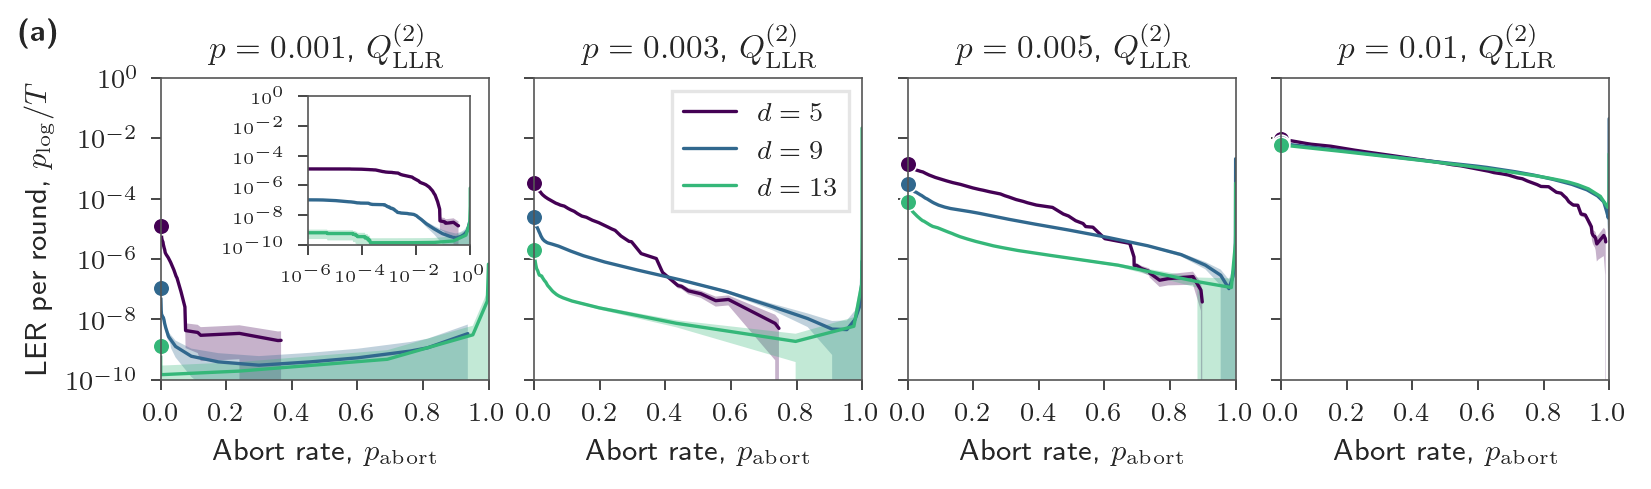

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# fig, axes = plt.subplots(
#     1, 4, figsize=(DFT_FIG_WIDTH_WIDE, 3), sharey=True, constrained_layout=True
# )

fig = FIG_FORMATTER.figure(wide=True, aspect_ratio=0.28)
axes = [fig.add_subplot(1, 4, 1)]
axes.extend([fig.add_subplot(1, 4, i + 1, sharey=axes[0]) for i in range(1, 4)])

d_values = [5, 9, 13]
p_values = [0.001, 0.003, 0.005, 0.01]

df_ps_matching_gap_all = df_ps_dict["matching_gap"]
df_ps = df_ps_dict["cluster_llr_norm_frac_2"]

# Create legend handles and labels
legend_handles = []
legend_labels = []

cmap = plt.get_cmap("viridis")

for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_d, d in enumerate(d_values):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        p_abort = df_ps_d["p_abort"].values
        p_fail = df_ps_d["p_fail"].values / d
        delta_p_fail = df_ps_d["delta_p_fail"].values / d
        line1 = error_band_plot(
            p_abort,
            p_fail,
            delta_p_fail,
            color=cmap(i_d / 3),
            label=rf"$d={d}$",
            ax=ax,
        )

        # Find minimum p_abort and corresponding LER per round
        min_p_abort_idx = np.argmin(p_abort)
        min_p_abort = p_abort[min_p_abort_idx]
        min_ler_per_round = p_fail[min_p_abort_idx]

        # Plot marker at minimum p_abort
        ax.plot(
            min_p_abort,
            min_ler_per_round,
            marker="o",
            color=cmap(i_d / 3),
            markersize=5,
            markeredgecolor="white",
            markeredgewidth=0.5,
            clip_on=False,
        )

    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1)
    ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
    ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
    ax.set_title(rf"$p = {p}$, $Q_\mathrm{{LLR}}^{{(2)}}$", fontsize=10)

    if i_p == 0:
        ax.set_ylabel(r"LER per round, $p_\mathrm{log} / T$")

    if i_p == 1:
        ax.legend(fontsize=8)

    if i_p != 0:
        ax.label_outer()

p = 1e-3
inset_ax = inset_axes(
    axes[0],
    width="50%",
    height="50%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 0.99, 0.99),
    bbox_transform=axes[0].transAxes,
)

for i_d, d in enumerate(d_values):
    df_ps_d = df_ps.loc[idx[d, d, p, :], :]
    p_abort = df_ps_d["p_abort"].values
    p_fail = df_ps_d["p_fail"].values / d
    delta_p_fail = df_ps_d["delta_p_fail"].values / d

    # Plot the same data on inset with log scale for x-axis
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=cmap(i_d / 3),
        ax=inset_ax,
    )

# Set inset properties
inset_ax.set_xscale("log")
inset_ax.set_yscale("log")
inset_ax.set_xlim(1e-6, 1)
inset_ax.set_xticks([1e-6, 1e-4, 1e-2, 1e0])
inset_ax.set_ylim(1e-10, 1)
inset_ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
inset_ax.tick_params(labelsize=5)

fig.text(
    0,
    1,
    r"\textbf{(a)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

fig.savefig("overleaf_figs/surface_code_plog_vs_pabort.pdf")

In [24]:
from simulations.analysis.plotting_helpers import (
    take_best_by_from_df_ps_dict,
    get_lower_envelope,
    error_band_plot,
)

In [ ]:
# def exclude(by):
#     if "cluster_llr_norm_frac" in by or "cluster_size_norm" in by:
#         if "norm_gap" not in by:
#             return False
#     return True


# df_ps_best = take_best_by_from_df_ps_dict(
#     df_ps_dict,
#     exclude=exclude,
#     use_pfail_upper=False,
# )

In [ ]:
from simulations.analysis.plotting_helpers import get_lower_envelope


def plot_plog_against_pabort(p, d, aspect_ratio=0.9):
    fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=aspect_ratio)
    ax = fig.add_subplot()

    df_ps_matching_gap_all = df_ps_dict["matching_gap"]

    def plot(df, **kwargs):
        df = df.reset_index()
        p_abort = df["p_abort"].values
        p_fail = df["p_fail"].values / d
        delta_p_fail = df["delta_p_fail"].values / d
        error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, **kwargs)

    # Best cluster norm
    df_ps_d = df_ps_dict["cluster_llr_norm_frac_2"].loc[idx[d, d, p, :], :]
    plot(df_ps_d, label=r"$Q_\mathrm{LLR}^{(2)}$")

    # Logical gap
    try:
        df_ps_matching_gap = df_ps_matching_gap_all.loc[idx[d, d, p, :], :]
        df_ps_matching_gap = get_lower_envelope(df_ps_matching_gap)
        plot(
            df_ps_matching_gap,
            label=rf"Logical gap (MWPM)",
            # color=COLORS(1),
            linestyle="--",
        )
    except KeyError:
        pass

    # Prediction LLR
    plot(
        df_ps_dict["pred_llr"].loc[idx[d, d, p, :], :],
        label=rf"Correction weight",
        # color=COLORS(2),
        linestyle="-.",
    )

    # Detector density
    plot(
        df_ps_dict["detector_density"].loc[idx[d, d, p, :], :],
        label=rf"Detector density",
        # color=COLORS(3),
        linestyle=":",
    )

    # ax.set_xscale("log")
    ax.set_title(rf"$d={d}$, $p={p}$", fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yscale("log")
    ax.legend(loc="upper right", fontsize=7)
    ax.set_ylim(1e-10, 1)

    ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
    ax.set_ylabel(r"LER per round, $p_\mathrm{log} / T$")

    return fig, ax

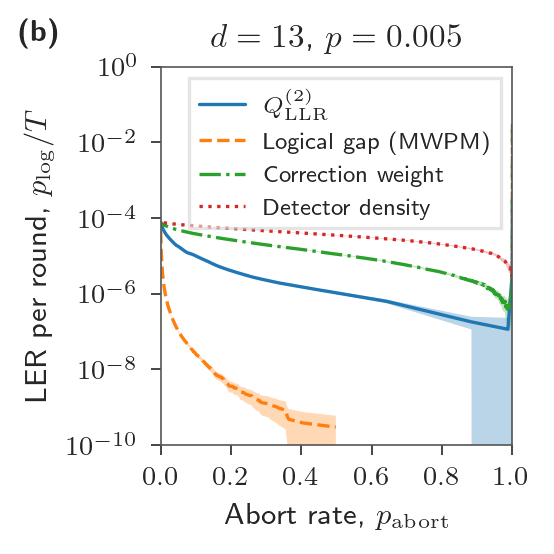

In [9]:
fig, ax = plot_plog_against_pabort(5e-3, 13, aspect_ratio=1)
fig.text(
    0,
    1,
    r"\textbf{(b)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)
plt.savefig(
    "overleaf_figs/surface_code_metric_comparison_plog_vs_pabort.pdf",
)

logical error rate vs spacetime cost (code distance & abort rate) at a physical error rate
or vs footprint (space cost)

In [10]:
d = T = 13
p = 5e-3

# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

i = 0
data_plots = {}
for by in ordered_keys:
    df_ps_all = df_ps_dict[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    try:
        df_ps = df_ps_all.loc[idx[d, T, p, :], :]
    except KeyError:
        continue

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

0: matching_gap (1.31e-09 ± 7.13e-10)
1: cluster_size_norm_frac_2 (2.32e-06 ± 9.84e-08)
2: cluster_llr_norm_frac_2 (2.36e-06 ± 9.90e-08)
3: cluster_llr_norm_frac_inf (2.68e-06 ± 1.05e-07)
4: cluster_llr_norm_frac_1 (2.69e-06 ± 1.05e-07)
5: cluster_size_norm_frac_inf (2.77e-06 ± 1.07e-07)
6: cluster_size_norm_frac_1 (2.96e-06 ± 1.10e-07)
7: pred_llr (1.93e-05 ± 2.86e-07)
8: cluster_llr_norm_frac_0.5 (3.32e-05 ± 3.74e-07)
9: cluster_size_norm_frac_0.5 (3.45e-05 ± 3.81e-07)
10: detector_density (4.64e-05 ± 4.38e-07)
7.734916682051773e-05
4.45004552697772e-05


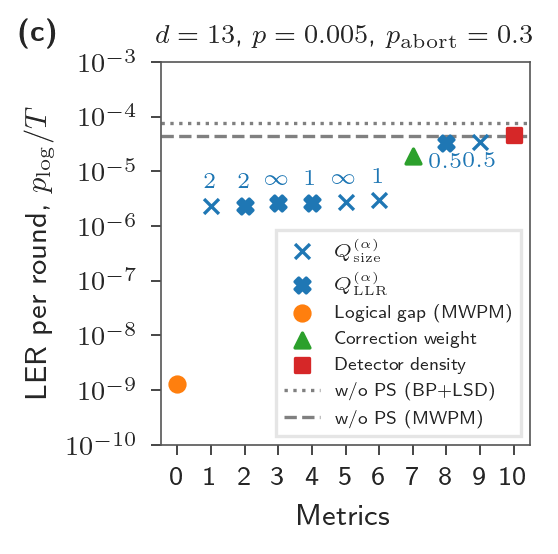

In [12]:
target = 0.3
bys, y_vals, y_errs = [], [], []

by_to_exclude = [
    "average_cluster_size",
    "average_cluster_llr",
    "matching_pred_llr",
    "matching_detector_density",
]

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    if by in by_to_exclude:
        continue
    if "norm" in by and "frac" not in by:
        continue
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")


def determine_group(by):
    if "matching" in by:
        group = 2
        color = COLORS(1)
        label = "Logical gap (MWPM)"
        marker = "o"
    elif "cluster_size_norm_frac" in by:
        group = 0
        label = r"$Q_\mathrm{size}^{(\alpha)}$"
        marker = "x"
        color = COLORS(0)
    elif "cluster_llr_norm_frac" in by:
        group = 1
        label = r"$Q_\mathrm{LLR}^{(\alpha)}$"
        marker = "X"
        color = COLORS(0)
    elif by == "pred_llr":
        group = 3
        label = "Correction weight"
        marker = "^"
        color = COLORS(2)
    elif by == "detector_density":
        group = 4
        label = "Detector density"
        marker = "s"
        color = COLORS(3)
    else:
        group = 7
        label = "other"
        marker = "s"
        color = COLORS(5)
    return group, label, marker, color


fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=1)
ax = fig.add_subplot()

# Group data and plot with different colors
group_labels_added = set()
legend_handles = []
legend_labels = []

unique_labels = set()

for i, by in enumerate(by_sorted):
    group, group_label, marker, color = determine_group(by)
    label = group_label if group_label not in group_labels_added else None
    if label in unique_labels:
        label = None

    handle = plt.scatter(
        i,
        y_vals_sorted[i],
        marker=marker,
        s=20,
        color=color,
        label=label,
    )

    # Add number annotation for "norm" metrics
    if "norm" in by:
        norm_order = by.split("_")[-1]
        if norm_order == "inf":
            norm_order = r"$\infty$"
        else:
            norm_order = rf"${norm_order}$"

        if norm_order != rf"$0.5$":
            y_text = y_vals_sorted[i] * 1.8
        else:
            y_text = y_vals_sorted[i] * 0.3
        plt.text(
            i,
            y_text,  # Position slightly above the marker
            norm_order,
            ha="center",
            va="bottom",
            fontsize=6.5,
            color=color,
        )

    if label:
        group_labels_added.add(group_label)
        legend_handles.append((group, handle))
        legend_labels.append((group, group_label))

pfail_org = (
    df_ps_dict["cluster_llr_norm_1"].loc[idx[d, d, p, :], "p_fail"].values[-1] / T
)
pfail_org_matching = (
    df_ps_dict["matching_gap"].loc[idx[d, d, p, :], "p_fail"].values[0] / T
)

line1 = plt.axhline(pfail_org, color="grey", linestyle=":", label="BP+LSD", zorder=0)
line2 = plt.axhline(
    pfail_org_matching, color="grey", linestyle="--", label="MWPM", zorder=0
)

print(pfail_org)
print(pfail_org_matching)


# Sort legend by group order
legend_handles.sort(key=lambda x: x[0])
legend_labels.sort(key=lambda x: x[0])

# Add axhline handles to legend
legend_handles.append((999, line1))  # Use high number to put at end
legend_labels.append((999, "w/o PS (BP+LSD)"))
legend_handles.append((1000, line2))  # Use higher number to put at end
legend_labels.append((1000, "w/o PS (MWPM)"))

plt.title(rf"$d = {d}$, $p = {p}$, $p_\mathrm{{abort}} = {target}$", fontsize=8)
plt.xticks(np.arange(len(by_sorted)), np.arange(len(by_sorted)))
plt.xlabel("Metrics")
plt.ylabel(r"LER per round, $p_\mathrm{log} / T$")
plt.yscale("log")
plt.ylim(1e-10, 1e-3)
plt.yticks(10.0 ** np.arange(-10, -2, 1))
plt.legend(
    [h[1] for h in legend_handles],
    [l[1] for l in legend_labels],
    loc="lower right",
    fontsize=5.5,
)
plt.grid(False)

fig.text(
    0,
    1,
    r"\textbf{(c)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

plt.savefig("overleaf_figs/surface_code_metric_comparison.pdf")

## Abort rate to achieve a target logical error rate

In [13]:
df_ps_dict_new = load_data(["surface", "surface_matching"], prefixes=["", "matching_"])

In [14]:
df_ps = df_ps_dict_new["cluster_llr_norm_frac_2"]
df_ps.head()

p_fail  delta_p_fail   p_abort  \
d T p     cluster_llr_norm_frac                                         
5 5 0.001 0.0000                 3.035875e-09  3.035875e-09  0.367323   
          0.0028                 2.991047e-09  2.991047e-09  0.357841   
          0.0029                 2.528041e-09  2.528041e-09  0.240230   
          0.0030                 2.425560e-09  2.425560e-09  0.208129   
          0.0031                 5.934074e-09  4.703695e-09  0.170767   

                                 delta_p_abort      count  num_fails  \
d T p     cluster_llr_norm_frac                                        
5 5 0.001 0.0000                      0.000030  632677324          0   
          0.0028                      0.000030  642159447          0   
          0.0029                      0.000026  759769814          0   
          0.0030                      0.000025  791870550          0   
          0.0031                      0.000023  829232925          3   

                                 p_fail_conv  delta_p_fail_conv  p_abort_conv  \
d T p     cluster_llr_norm_frac                                                 
5 5 0.001 0.0000                    0.000034       3.594929e-07      0.002699   
          0.0028                    0.000034       3.594929e-07      0.002699   
          0.0029                    0.000034       3.594929e-07      0.002699   
          0.0030                    0.000034       3.594929e-07      0.002699   
          0.0031                    0.000034       3.594929e-07      0.002699   

                                 delta_p_abort_conv   count_conv  \
d T p     cluster_llr_norm_frac                                    
5 5 0.001 0.0000                           0.000003  997300721.0   
          0.0028                           0.000003  997300721.0   
          0.0029                           0.000003  997300721.0   
          0.0030                           0.000003  997300721.0   
          0.0031                           0.000003  997300721.0   

                                 num_fails_conv  
d T p     cluster_llr_norm_frac                  
5 5 0.001 0.0000                          33461  
          0.0028                          33461  
          0.0029                          33461  
          0.0030                          33461  
          0.0031                          33461

In [108]:
from simulations.analysis.plotting_helpers import get_required_abort_rate

get_required_abort_rate(
    df_ps_sng=df_ps_dict_new["cluster_llr_norm_2"].loc[(9, 9, 5e-3)],
    target_ler=1e-3 / 12,
)

{'p_abort': 0.4858520968478286,
 'p_abort_low': 0.4824846868909478,
 'p_abort_upp': 0.4892745234706716,
 'shots': 300000000,
 'p_fail_org': 0.002642429701928751}

### Metric comparison

In [90]:
# Add cluster_size_norm and cluster_llr_norm metrics with specific format
import re

by_list = []
for key in df_ps_dict.keys():
    if re.match(r"^cluster_size_norm_\d+(\.\d+)?$", key) or re.match(
        r"^cluster_llr_norm_\d+(\.\d+)?$", key
    ):
        by_list.append(key)

by_list.extend(["matching_gap", "pred_llr", "detector_density"])
by_list

['cluster_llr_norm_2', 'matching_gap', 'pred_llr', 'detector_density']

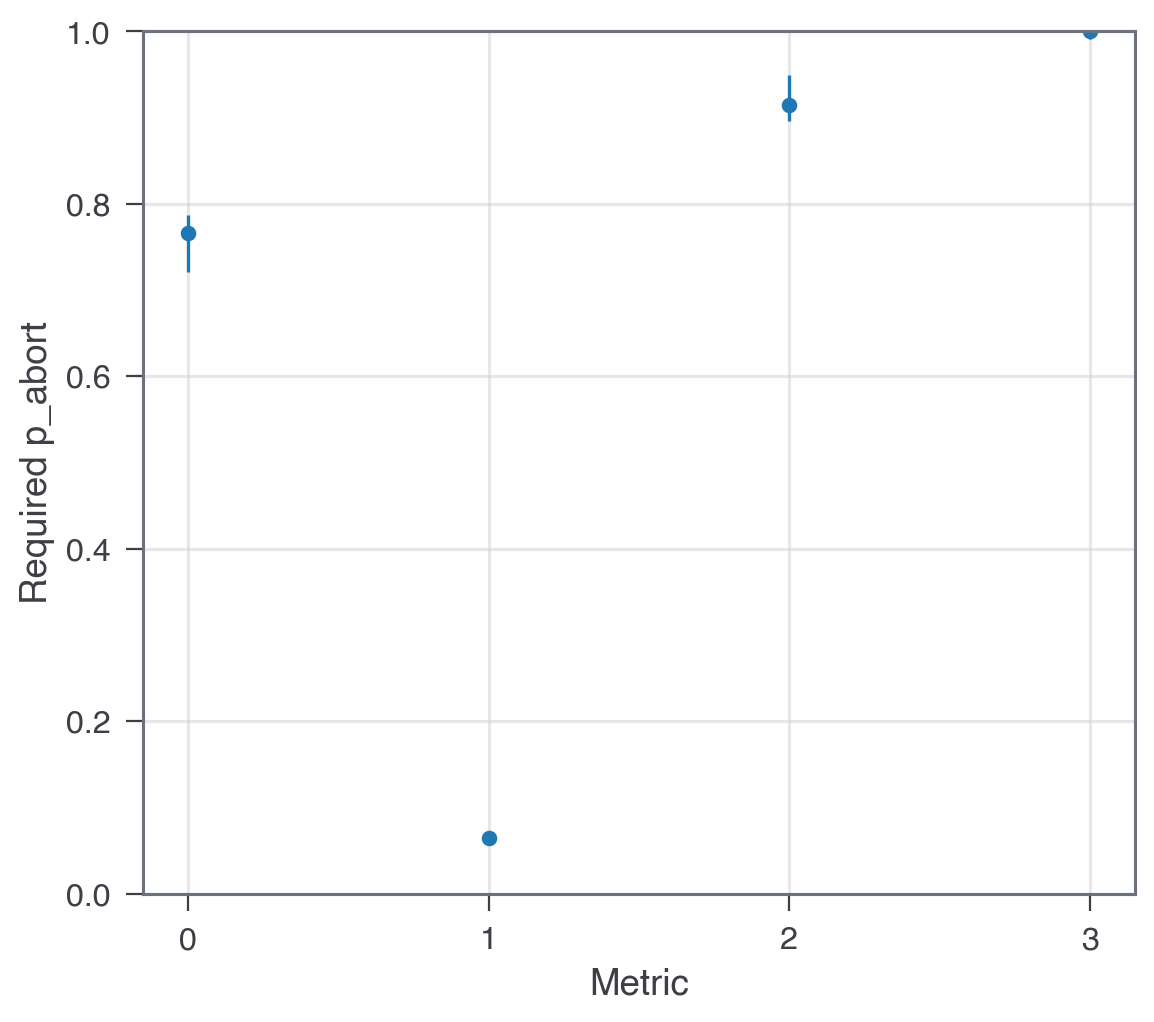

In [107]:
def draw_sng_target(target_suppression, d, p, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_vals = []
    y_vals = []
    y_errs_low = []
    y_errs_upp = []

    for by in by_list:
        results = get_required_abort_rate(
            by, d=d, p=p, target_suppression=target_suppression
        )
        x_vals.append(by)
        y_vals.append(results["p_abort"])
        y_errs_low.append(results["p_abort"] - results["p_abort_low"])
        y_errs_upp.append(results["p_abort_upp"] - results["p_abort"])

    # Create error bars using asymmetric errors
    yerr = [y_errs_low, y_errs_upp]

    ax.errorbar(x_vals, y_vals, yerr=yerr, fmt="o", capsize=5)
    ax.set_xlabel("Metric")
    by_list_indices = np.arange(len(by_list))
    ax.set_xticks(by_list_indices)
    ax.set_xticklabels(by_list_indices)
    ax.set_ylabel("Required p_abort")

    ax.set_ylim(0, 1)


draw_sng_target(1e-2, 9, 5e-3)

### Abort rate vs p

In [15]:
from simulations.analysis.plotting_helpers import get_required_abort_rate


def plot_required_abort_rate(
    by,
    target_suppression,
    fix_ler=False,
    plot_cost=False,
    ler_per_round=True,
    ax=None,
    title="default",
    show_only_plots=False,
    plot_kwargs=None,
    xlim=(0, 1.2e-2),
    ylim=(0, 1),
):
    df_ps = df_ps_dict_new[by]

    plist = df_ps.index.get_level_values("p").unique()
    dlist = [5, 9, 13]

    results = []

    for d in dlist:
        for p in plist:
            df_ps_sng = df_ps.loc[(d, d, p)]
            if fix_ler:
                target_ler = target_suppression
                if ler_per_round:
                    target_ler *= d
                results_sng = get_required_abort_rate(df_ps_sng, target_ler=target_ler)

            else:
                results_sng = get_required_abort_rate(
                    df_ps_sng, target_suppression=target_suppression
                )

            p_abort = results_sng["p_abort"]
            p_abort_lower = results_sng["p_abort_low"]
            p_abort_upper = results_sng["p_abort_upp"]

            results.append(
                {
                    "d": d,
                    "p": p,
                    "p_abort": p_abort,
                    "p_abort_lower": p_abort_lower,
                    "p_abort_upper": p_abort_upper,
                }
            )

    # Convert results to DataFrame for plotting
    results_df = pd.DataFrame(results)

    if plot_cost:
        d_all = results_df["d"]
        cost = (2 * d_all**2 - 1) * d_all
        results_df["cost"] = cost / (1 - results_df["p_abort"])
        results_df["cost_lower"] = cost / (1 - results_df["p_abort_lower"])
        results_df["cost_upper"] = cost / (1 - results_df["p_abort_upper"])

    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(layout="constrained")

    for d in dlist:
        d_data = results_df[results_df["d"] == d]
        d_data = d_data.sort_values("p_abort")
        last_zero_lower_idx = d_data[d_data["p_abort_lower"] < 1e-5].index
        first_one_upper_idx = d_data[d_data["p_abort_upper"] > 1 - 1e-5].index

        if len(last_zero_lower_idx) > 0 and len(first_one_upper_idx) > 0:
            start_idx = last_zero_lower_idx[-1]  # Last row where p_abort_lower is 0
            end_idx = first_one_upper_idx[0]  # First row where p_abort_upper is 1
            d_data = d_data.loc[start_idx:end_idx]
        elif len(last_zero_lower_idx) > 0:
            # If no p_abort_upper == 1, start from last p_abort_lower == 0
            start_idx = last_zero_lower_idx[-1]
            d_data = d_data.loc[start_idx:]
        elif len(first_one_upper_idx) > 0:
            # If no p_abort_lower == 0, end at first p_abort_upper == 1
            end_idx = first_one_upper_idx[0]
            d_data = d_data.loc[:end_idx]

        if not d_data.empty:
            col = "cost" if plot_cost else "p_abort"
            col_lower = "cost_lower" if plot_cost else "p_abort_lower"
            col_upper = "cost_upper" if plot_cost else "p_abort_upper"

            delta_y_lower = d_data[col] - d_data[col_lower]
            delta_y_upper = d_data[col_upper] - d_data[col]

            mask = delta_y_upper != np.inf

            kwargs = {
                "marker": "o",
                "capsize": 3,
                "capthick": 1,
                "barsabove": True,
                "label": rf"$d = {d}$",
            }
            if plot_kwargs is not None:
                kwargs.update(plot_kwargs[d])

            ax.errorbar(
                d_data["p"][mask],
                d_data[col][mask],
                yerr=[
                    delta_y_lower[mask],
                    delta_y_upper[mask],
                ],
                **kwargs,
            )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    if not show_only_plots:
        ax.set_xlabel(r"Physical error rate, $p$")
        ax.set_ylabel(r"Required abort rate, $p_\mathrm{abort}$")
        if title == "default":
            if fix_ler:
                ax.set_title(
                    rf"Target $p_\mathrm{{log}} / T = {target_suppression}$"
                    + f"\nby={by}"
                )
            else:
                ax.set_title(
                    rf"Target Suppression = {target_suppression}" + f"\nby={by}"
                )
        elif title:
            ax.set_title(title)
        ax.legend()
    return ax

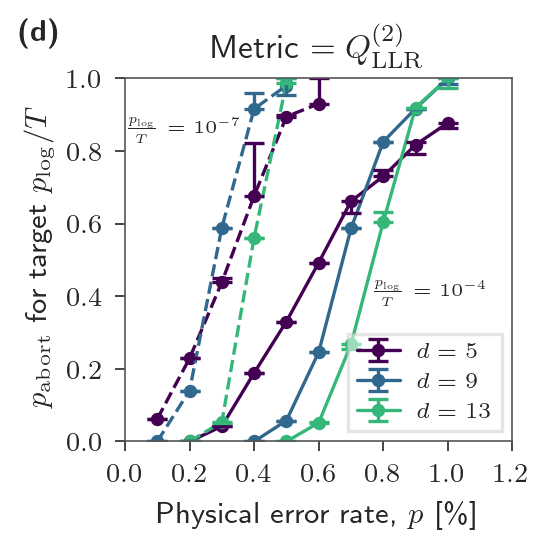

In [16]:
from matplotlib import ticker

fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=1)
ax = fig.add_subplot()

target_lers = [1e-4, 1e-7]

cmap = plt.get_cmap("viridis")

for i, target_ler in enumerate(target_lers):
    plot_kwargs = {}
    for i_d, d in enumerate([5, 9, 13]):
        if i == 0:
            linestyle = "-"
            label = rf"$d = {d}$"
        else:
            linestyle = "--"
            label = None

        plot_kwargs_d = {
            "color": cmap(i_d / 3),
            "linestyle": linestyle,
            "label": label,
        }
        plot_kwargs[d] = plot_kwargs_d

    plot_required_abort_rate(
        "cluster_llr_norm_frac_2",
        target_ler,
        ax=ax,
        fix_ler=True,
        title=False,
        show_only_plots=True,
        plot_kwargs=plot_kwargs,
    )

ax.text(0.0077, 0.4, r"$\frac{p_\mathrm{log}}{T} = 10^{-4}$", fontsize=5.5)
ax.text(0.0001, 0.85, r"$\frac{p_\mathrm{log}}{T} = 10^{-7}$", fontsize=5.5)

ax.set_xlabel(r"Physical error rate, $p$ [\%]")
ax.set_ylabel(r"$p_\mathrm{abort}$ for target $p_\mathrm{log}/T$")
ax.set_xlim(0, 1.2e-2)
xticks = np.arange(0, 0.013, 0.002).round(decimals=3)
xtick_labels = [rf"${xtick * 100:.1f}$" for xtick in xticks]
ax.set_xticks(xticks, xtick_labels)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))

ax.legend(fontsize=6.5)
ax.set_title(r"Metric $= Q_\mathrm{LLR}^{(2)}$", fontsize=10)

# fig.tight_layout(pad=0)

fig.text(
    0,
    1,
    r"\textbf{(d)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

fig.savefig("overleaf_figs/surface_code_target_ler.pdf")

/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3825: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3825: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


Text(0, 1, '(d)')

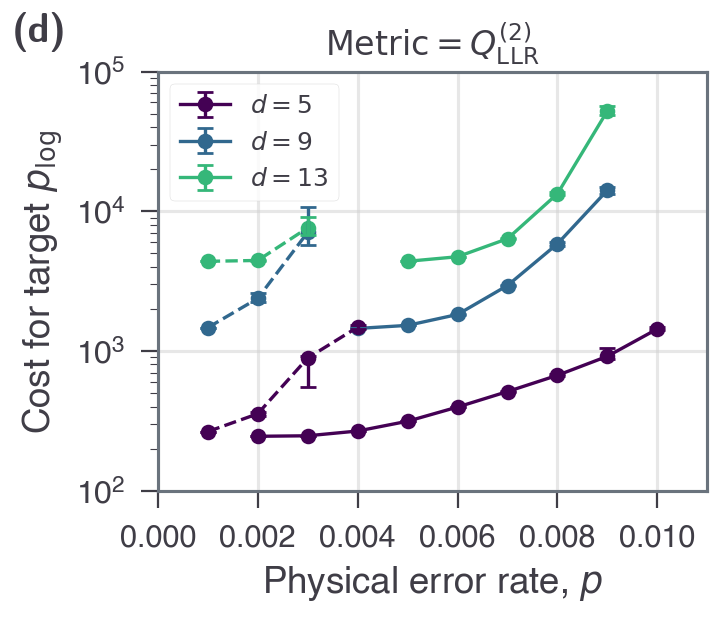

In [ ]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH_WIDE * 0.32, 3), constrained_layout=True)

target_lers = [1e-3, 1e-7]

cmap = plt.get_cmap("viridis")

for i, target_ler in enumerate(target_lers):
    plot_kwargs = {}
    for i_d, d in enumerate([5, 9, 13]):
        if i == 0:
            linestyle = "-"
            label = rf"$d = {d}$"
        else:
            linestyle = "--"
            label = None

        plot_kwargs_d = {
            "color": cmap(i_d / 3),
            "linestyle": linestyle,
            "label": label,
        }
        plot_kwargs[d] = plot_kwargs_d

    plot_required_abort_rate(
        "cluster_llr_norm_2",
        target_ler,
        ax=ax,
        fix_ler=True,
        plot_cost=True,
        ler_per_round=False,
        ylim=None,
        title=False,
        show_only_plots=True,
        plot_kwargs=plot_kwargs,
    )

# ax.text(0.0082, 0.45, r"$\frac{p_\mathrm{log}}{T} = 10^{-4}$", fontsize=10)
# ax.text(0.00035, 0.7, r"$\frac{p_\mathrm{log}}{T} = 10^{-7}$", fontsize=10)

ax.set_xlabel(r"Physical error rate, $p$")
ax.set_ylabel(r"Cost for target $p_\mathrm{log}$")
ax.set_xlim(0, 1.1e-2)
ax.set_xticks(np.arange(0, 1.1e-2, 2e-3))
ax.set_ylim(1e2, 1e5)
# ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_yscale("log")
ax.tick_params(axis="x", labelsize=11)

ax.legend(fontsize=9)
ax.set_title(r"$\text{Metric} = Q_\mathrm{LLR}^{(2)}$", fontsize=12)

ax.text(
    0,
    1,
    "(d)",
    transform=fig.transFigure,
    fontdict=dict(weight="bold", family=CMU_FONT),
    va="top",
    ha="left",
    in_layout=False,
    fontsize=14,
)

# fig.savefig("overleaf_figs/surface_code_target_ler.pdf")

Text(0.04, 0.94, '(d)')

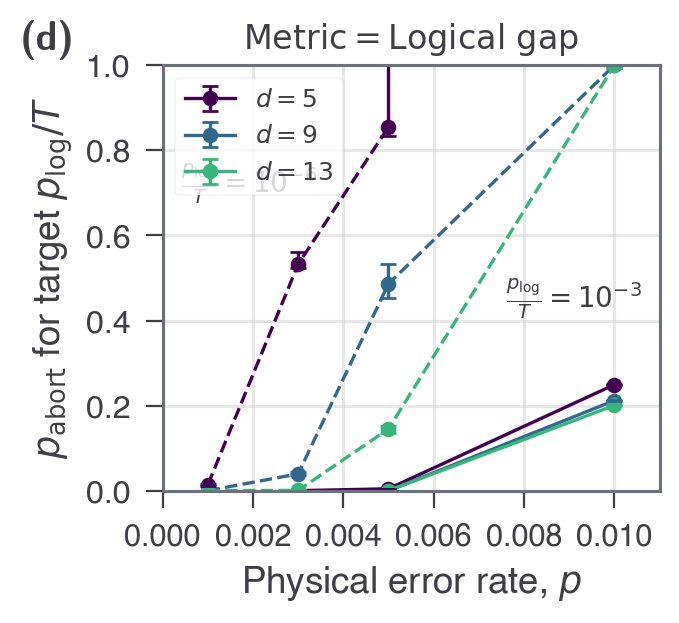

In [ ]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH_WIDE * 0.32, 3.3))

target_lers = [1e-3, 1e-6]

cmap = plt.get_cmap("viridis")

for target_ler in target_lers:
    plot_kwargs = {}
    for i_d, d in enumerate([5, 9, 13]):
        if target_ler == 1e-3:
            linestyle = "-"
            label = rf"$d = {d}$"
        else:
            linestyle = "--"
            label = None

        plot_kwargs_d = {
            "color": cmap(i_d / 3),
            "linestyle": linestyle,
            "label": label,
        }
        plot_kwargs[d] = plot_kwargs_d

    plot_required_abort_rate(
        "matching_gap",
        target_ler,
        ax=ax,
        fix_ler=True,
        title=False,
        show_only_plots=True,
        plot_kwargs=plot_kwargs,
    )

ax.text(0.0076, 0.43, r"$\frac{p_\mathrm{log}}{T} = 10^{-3}$", fontsize=10)
ax.text(0.0004, 0.7, r"$\frac{p_\mathrm{log}}{T} = 10^{-6}$", fontsize=10)

ax.set_xlabel(r"Physical error rate, $p$")
ax.set_ylabel(r"$p_\mathrm{abort}$ for target $p_\mathrm{log}/T$")
ax.set_xlim(0, 1.1e-2)
ax.set_xticks(np.arange(0, 1.1e-2, 2e-3))
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.tick_params(axis="x", labelsize=11)

ax.legend(fontsize=9)
ax.set_title(r"$\text{Metric} = \text{Logical gap}$", fontsize=12)

fig.tight_layout()

ax.text(
    0.04,
    0.94,
    "(d)",
    transform=fig.transFigure,
    fontdict=dict(weight="bold", family=CMU),
    verticalalignment="top",
    fontsize=14,
)

# fig.savefig("overleaf_figs/surface_code_target_ler.pdf")

### Cost analysis

## LER & AR vs metric

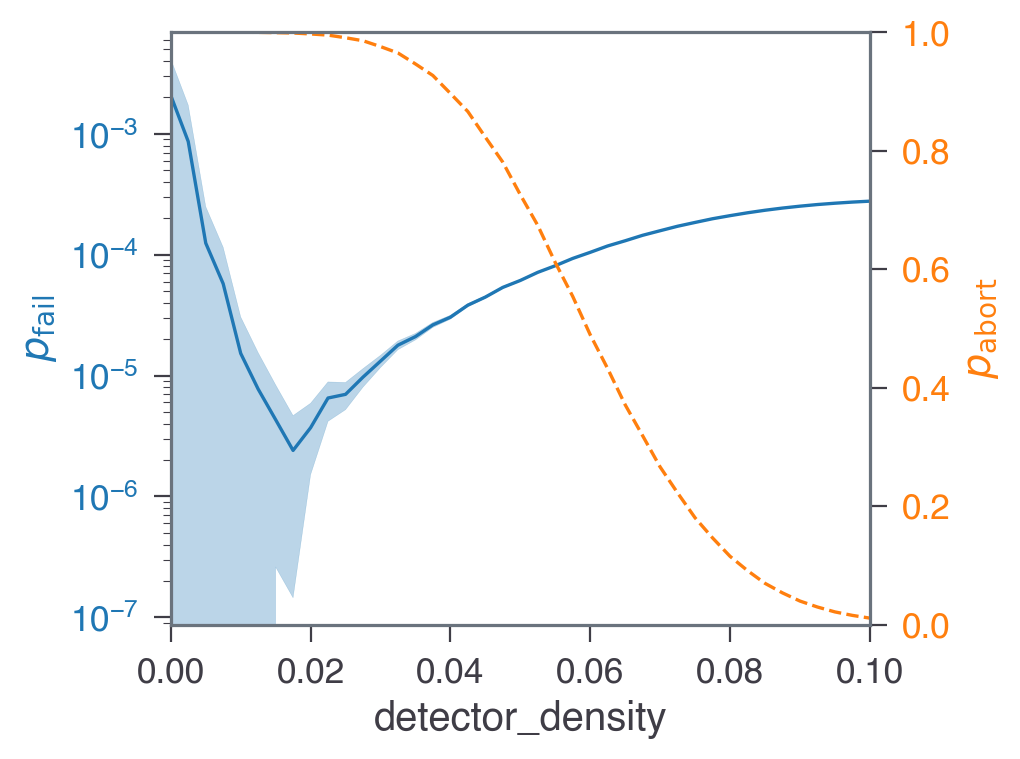

In [115]:
d = T = 9
p = 0.005
by = "detector_density"

df_ps = df_ps_dict[by].loc[idx[d, T, p, :], :]

x_vals = df_ps.index.get_level_values(3).values
p_fail = df_ps["p_fail"].values / T
delta_p_fail = df_ps["delta_p_fail"].values / T
p_abort = df_ps["p_abort"].values

fig, ax1 = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

color1 = COLORS(0)
color2 = COLORS(1)

# ax1.plot(x_vals, p_fail, color=color1, label="p_fail")
error_band_plot(x_vals, p_fail, delta_p_fail, ax=ax1, color=color1)
ax1.set_ylabel(r"$p_\mathrm{fail}$", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel(by)
ax1.set_yscale("log")
ax1.set_xlim(0, 0.1)

ax2 = ax1.twinx()
ax2.plot(x_vals, p_abort, color=color2, label="p_abort", linestyle="--")
ax2.set_ylabel(r"$p_\mathrm{abort}$", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)
# ax2.set_yscale("log")
ax2.set_ylim(0, 1)

fig.tight_layout()

## pfail vs p for a fixed abort rate

In [532]:
df_ps_dict_new = load_data(["surface", "surface_matching"], prefixes=["", "matching_"])

In [538]:
df_ps_dp

,p_fail,delta_p_fail,p_abort,delta_p_abort,count,num_fails,p_fail_conv,delta_p_fail_conv,p_abort_conv,delta_p_abort_conv,count_conv,num_fails_conv
cluster_llr_norm,,,,,,,,,,,,
26.95,0.396725,0.396725,0.999997,0.000003,1,0,0.002178,0.000854,0.989021,0.000204,10977.0,22
27.27,0.328810,0.328810,0.999996,0.000003,2,0,0.002178,0.000854,0.989021,0.000204,10977.0,22
27.36,0.280749,0.280749,0.999995,0.000004,3,0,0.002178,0.000854,0.989021,0.000204,10977.0,22
27.47,0.244945,0.244945,0.999994,0.000004,4,0,0.002178,0.000854,0.989021,0.000204,10977.0,22
27.60,0.217241,0.217241,0.999993,0.000005,5,0,0.002178,0.000854,0.989020,0.000204,10978.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...
2403.14,0.077352,0.000524,0.000006,0.000004,999996,77350,0.077352,0.000524,0.000006,0.000004,999996.0,77350
2431.36,0.077352,0.000524,0.000005,0.000004,999997,77350,0.077352,0.000524,0.000005,0.000004,999997.0,77350
2531.92,0.077352,0.000524,0.000004,0.000003,999998,77350,0.077352,0.000524,0.000004,0.000003,999998.0,77350


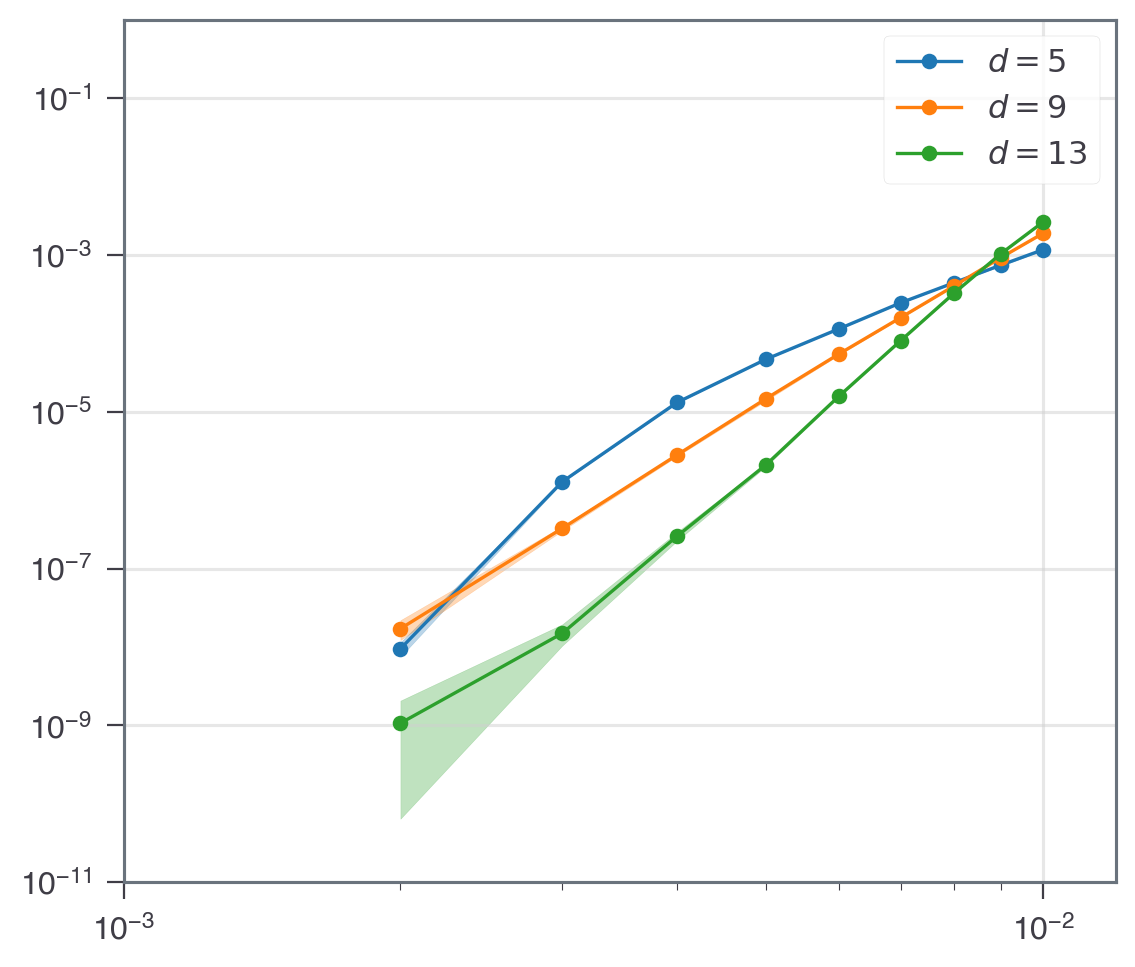

In [574]:
by = "cluster_llr_norm_2"
target_p_abort = 0.3

df_ps = df_ps_dict_new[by]
dlist = [5, 9, 13]
for i_d, d in enumerate(dlist):
    df_ps_d = df_ps.loc[(d, d)]
    plist = df_ps_d.index.get_level_values("p").unique()
    pfails = []
    delta_pfails = []
    for i_p, p in enumerate(plist):
        df_ps_dp = df_ps_d.loc[p].sort_values("p_abort")
        inds = np.where(df_ps_dp["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_dp.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_dp.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    pfails = np.array(pfails)
    delta_pfails = np.array(delta_pfails)

    mask = delta_pfails / pfails < 1
    error_band_plot(
        plist[mask],
        pfails[mask],
        delta_pfails[mask],
        label=f"$d={d}$",
        marker="o",
        color=COLORS(i_d),
        # marker="o",
        # capsize=3,  # Add caps (heads) to the error bars
        # capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.xlim(1e-3, 0.012)
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-11, 1)
plt.legend()

## pfail vs d for a fixed abort rate

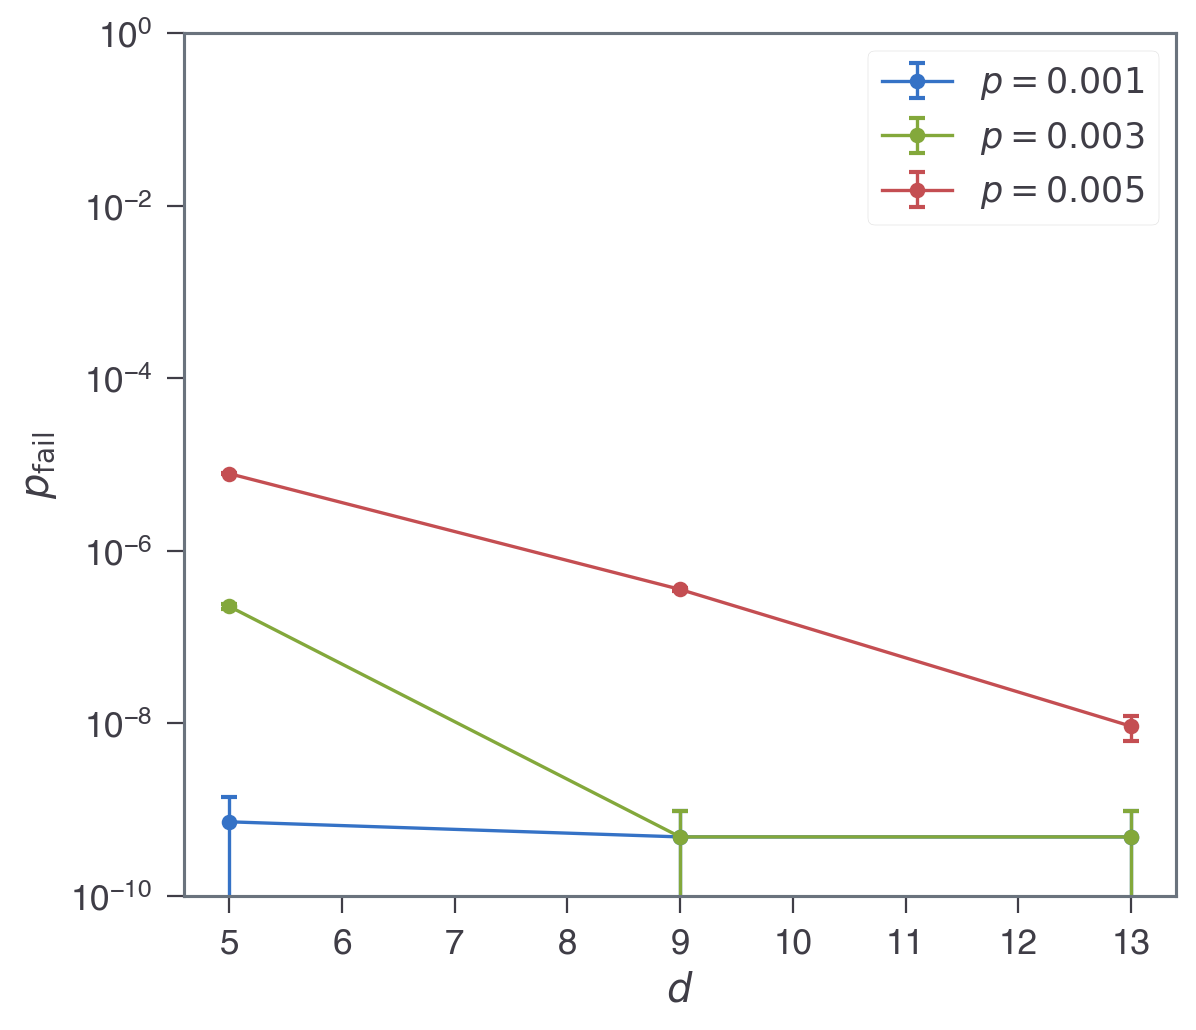

In [104]:
by = "matching_gap"
target_p_abort = 0.2

df_ps = df_ps_dict[by]
plist = df_ps.index.get_level_values("p").unique()
dlist = df_ps.index.get_level_values("d").unique()

for i_p, p in enumerate(plist):
    pfails = []
    delta_pfails = []
    for i_d, d in enumerate(dlist):
        df_ps_d = df_ps.loc[idx[d, d, p, :], :]
        inds = np.where(df_ps_d["p_abort"] <= target_p_abort)[0]
        if len(inds):
            ind = inds[-1]
        else:
            ind = 0
        pfail = df_ps_d.iloc[ind]["p_fail"] / T
        delta_pfail = df_ps_d.iloc[ind]["delta_p_fail"] / T
        pfails.append(pfail)
        delta_pfails.append(delta_pfail)

    plt.errorbar(
        dlist,
        pfails,
        yerr=delta_pfails,
        label=f"$p={p}$",
        marker="o",
        capsize=3,  # Add caps (heads) to the error bars
        capthick=1.5,  # Make the cap (head) lines thicker for visibility
    )

plt.yscale("log")
plt.ylim(1e-10, 1)
plt.xlabel("$d$")
plt.ylabel("$p_{\\mathrm{fail}}$")
plt.legend()

## Cluster norm distribution

In [14]:
df_agg_dict = load_data(
    ["surface", "surface_matching"], "agg", prefixes=["", "matching_"]
)

Text(0.5, 0, 'Cluster LLR norm gap (order = $\\infty$)')

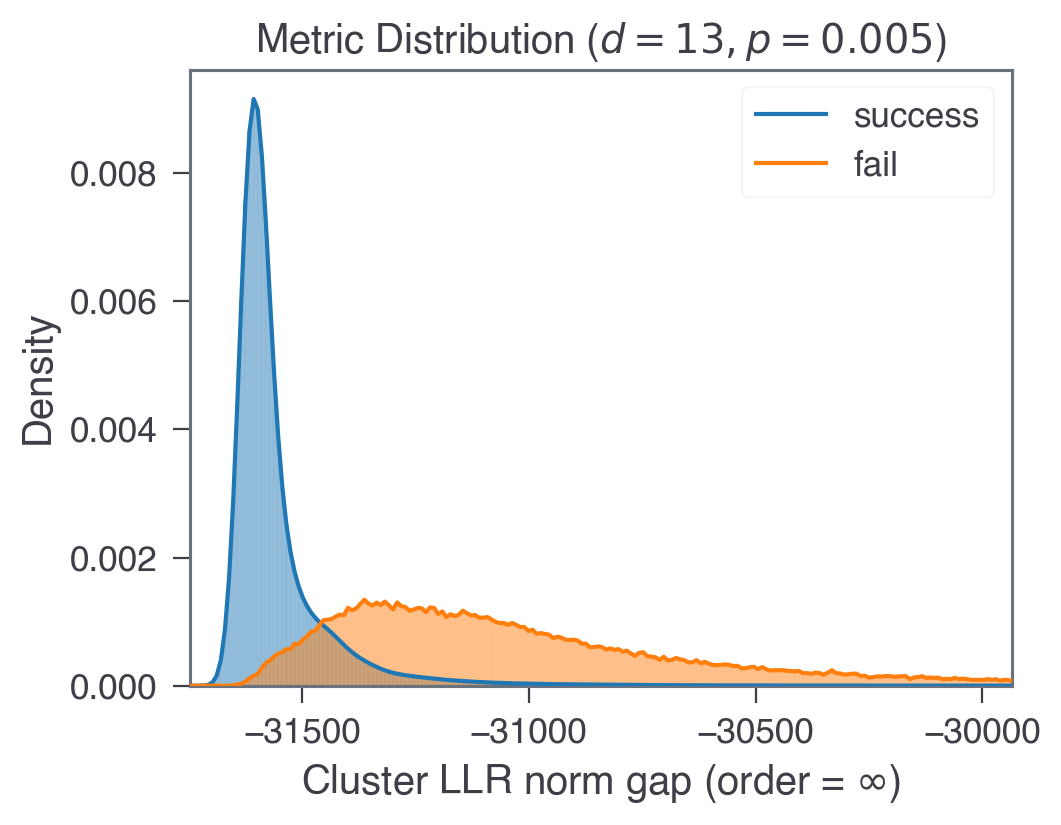

In [21]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

# by = "cluster_llr_norm_gap_1"
by = "cluster_llr_norm_gap_inf"
d = T = 13
p = 5e-3

df_agg = df_agg_dict[by].loc[(d, T, p)]
df_agg_plot = df_agg.copy()
df_agg_plot.index = -df_agg_plot.index

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg_plot,
    bins=1000,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    upper_trim_frac=5e-2,
)

ax.set_title(rf"Metric Distribution ($d = {d}, p = {p}$)")
ax.set_xlabel(r"Cluster LLR norm gap (order = $\infty$)")

### Discrimination power

In [87]:
# With aggregated data

from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_agg,
)

d = T = 9
p = 5e-3
for by in ["cluster_llr_norm", "cluster_llr_norm_gap"]:
    for norm_order in [0.5, 1, 2, "inf"]:
        by_name = f"{by}_{norm_order}"
        ascending_confidence = True if "gap" in by_name else False

        df_agg = df_agg_dict[by_name].loc[(d, T, p)]
        df_agg["num_succs"] = df_agg["count"] - df_agg["num_fails"]

        auprc_lift = calculate_discrimination_metrics_from_agg(
            metric_values=df_agg.index.values,
            counts=df_agg["count"],
            num_fails=df_agg["num_fails"],
            method="lift",
            ascending_confidence=ascending_confidence,
        )
        print(f"{by_name}: {auprc_lift}")

cluster_llr_norm_0.5: 6.3127126949764
cluster_llr_norm_1: 25.021235866613775
cluster_llr_norm_2: 21.579863260749274
cluster_llr_norm_inf: 20.3559156377191
cluster_llr_norm_gap_0.5: 8.22328092228908
cluster_llr_norm_gap_1: 25.021234558887592
cluster_llr_norm_gap_2: 23.517509632593157
cluster_llr_norm_gap_inf: 22.99702144513394


In [138]:
# With raw data
from simulations.analysis.data_aggregation import extract_sample_metric_values

data_dir = f"../../data/surface_code_minsum_iter30_lsd0/d{d}_T{T}_p{p}"
metric_values = extract_sample_metric_values(
    data_dir=data_dir, by=by, norm_order=norm_order, dtype="float32"
)
fails = extract_sample_metric_values(
    data_dir=data_dir,
    by="fail",
    dtype="bool",
)

Extracting fail values: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


In [140]:
from simulations.analysis.plotting_helpers import (
    calculate_discrimination_metrics_from_raw,
)

calculate_discrimination_metrics_from_raw(
    metric_values=metric_values,
    fails=fails,
    method="auprc",
    ascending_confidence=True,
)

0.0623134526851848

In [91]:
list(df_agg_dict.keys())

['cluster_llr_norm_2',
 'cluster_size_norm_gap_inf',
 'cluster_llr_norm_gap_0.5',
 'cluster_size_norm_inf',
 'cluster_llr_norm_gap_1',
 'cluster_llr_norm_0.5',
 'cluster_size_norm_1',
 'detector_density',
 'cluster_size_norm_gap_1',
 'cluster_llr_norm_1',
 'cluster_llr_norm_inf',
 'average_cluster_size',
 'cluster_size_norm_0.5',
 'cluster_llr_norm_gap_inf',
 'cluster_size_norm_2',
 'cluster_size_norm_gap_0.5',
 'cluster_llr_norm_gap_2',
 'pred_llr',
 'cluster_size_norm_gap_2',
 'average_cluster_llr',
 'matching_detector_density',
 'matching_gap',
 'matching_pred_llr']

In [92]:
# Find the point where cumulative count reaches "fraction" of total count
df_agg = df_agg_dict["cluster_llr_norm_2"]
total_count = df_agg["count"].sum()
cumsum = df_agg["count"].cumsum()
fraction = 1e-4
threshold_count = total_count * fraction
min_index = df_agg.index[cumsum >= threshold_count].min()
bin_range = (min_index, df_agg.index.max())
bins = 100

by_name = df_agg.index.name

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(0),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_succs",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="success",
    color=COLORS(0),
    element="poly",
    linewidth=1.5,
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    alpha=0.4,
    color=COLORS(1),
)

sns.histplot(
    df_agg.reset_index(),
    x=by_name,
    weights="num_fails",
    bins=bins,
    stat="density",
    binrange=bin_range,
    fill=False,
    label="fail",
    color=COLORS(1),
    element="poly",
    linewidth=1.5,
)
plt.legend()
plt.xlabel(by)

ValueError: The following variable cannot be assigned with wide-form data: `weights`

## Phenomenological noise

In [117]:
df_ps_dict_phenom = load_data(["surface_phenom"])

In [109]:
print(list(df_ps_dict_phenom.keys()))

['detector_density', 'cluster_llr_norm_gap_2', 'pred_llr']


In [359]:
df_ps_dict_phenom["cluster_llr_norm_gap_2"].head()

p_fail  delta_p_fail       p_abort  \
d  T  p     cluster_llr_norm_gap                                        
13 13 0.015 12170.842957          0.00019      0.000009  1.920729e-07   
            12561.262286          0.00019      0.000009  2.920728e-07   
            12572.320405          0.00019      0.000009  3.920728e-07   
            12592.405562          0.00019      0.000009  4.920728e-07   
            12606.171792          0.00019      0.000009  5.920727e-07   

                                  delta_p_abort     count  num_fails  \
d  T  p     cluster_llr_norm_gap                                       
13 13 0.015 12170.842957           1.920729e-07  10000000       1897   
            12561.262286           2.744204e-07   9999999       1897   
            12572.320405           3.372256e-07   9999998       1897   
            12592.405562           3.900457e-07   9999997       1897   
            12606.171792           4.365205e-07   9999996       1897   

                                  p_fail_conv  delta_p_fail_conv  \
d  T  p     cluster_llr_norm_gap                                   
13 13 0.015 12170.842957              0.00019           0.000009   
            12561.262286              0.00019           0.000009   
            12572.320405              0.00019           0.000009   
            12592.405562              0.00019           0.000009   
            12606.171792              0.00019           0.000009   

                                  p_abort_conv  delta_p_abort_conv  \
d  T  p     cluster_llr_norm_gap                                     
13 13 0.015 12170.842957          1.920729e-07        1.920729e-07   
            12561.262286          2.920728e-07        2.744204e-07   
            12572.320405          3.920728e-07        3.372256e-07   
            12592.405562          4.920728e-07        3.900457e-07   
            12606.171792          5.920727e-07        4.365205e-07   

                                  count_conv  num_fails_conv  
d  T  p     cluster_llr_norm_gap                              
13 13 0.015 12170.842957            10000000            1897  
            12561.262286             9999999            1897  
            12572.320405             9999998            1897  
            12592.405562             9999997            1897  
            12606.171792             9999996            1897

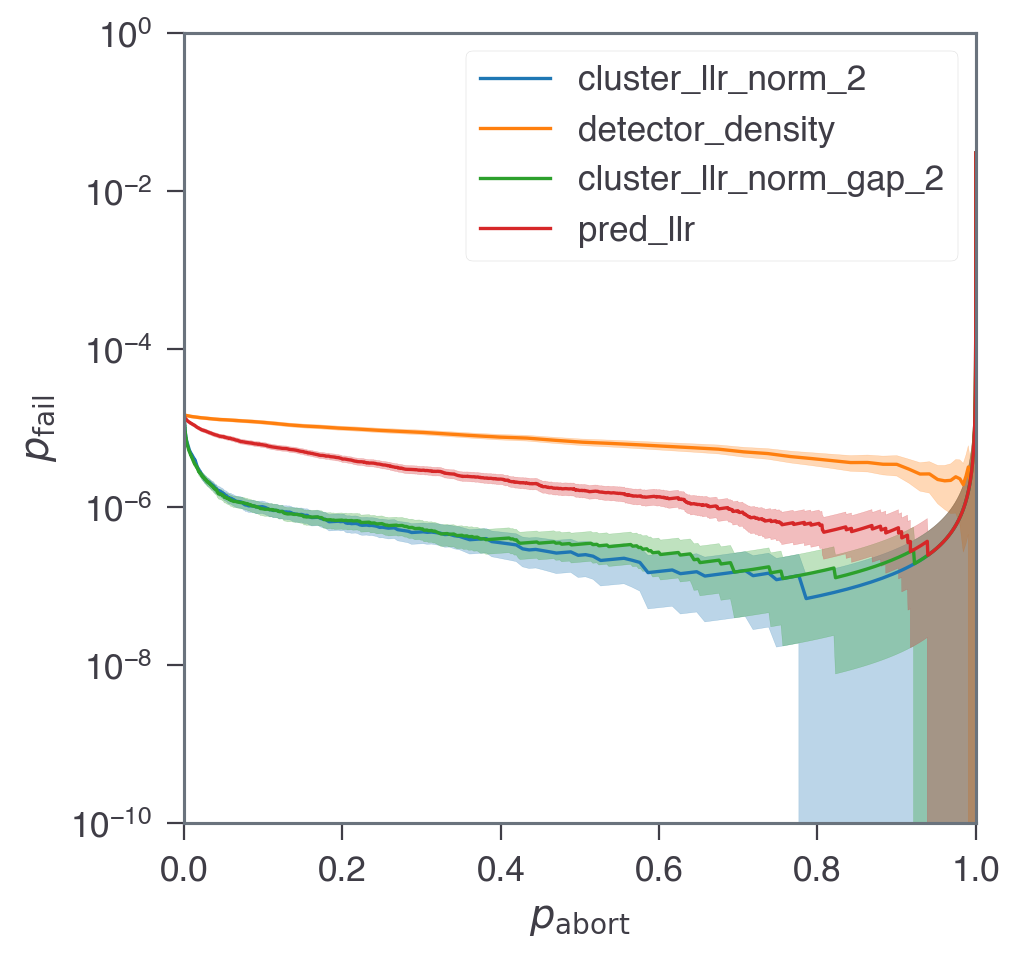

In [360]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

d = T = 13
p = 0.015

i = 0
data_plots = {}
for by in df_ps_dict_phenom.keys():
    df_ps_all = df_ps_dict_phenom[by]
    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    try:
        df_ps = df_ps_all.loc[idx[d, T, p, :], :]
    except KeyError:
        continue

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values / T
    delta_p_fail = df_ps[delta_p_fail_col].values / T
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-10, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()